# Deep Deterministic Policy Gradient (DDPG)
---
This notebook implements a DDPG agent with Unity's Udacity-modified Reacher environment.

### 1. Import the Necessary Packages

In [1]:
import gym
import random
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline
import time

### 2. Instantiate the Environment and Agent

Initialize the environment in the code cell below. 

Change the __*visible_environment*__ variable to enable training with (True) or without (False) a visible environment.

The output below indicates the utilization of a cpu or a gpu.

In [2]:
from unityagents import UnityEnvironment

# set these parameters
visible_environment = True 
one_agent = True # if false, then 20 agent environment

if visible_environment == True and one_agent == True:
    env = UnityEnvironment(file_name='../unity_environments/Reacher/Vis_one_agent/Reacher.x86_64')
elif visible_environment == False and one_agent == True:
    env = UnityEnvironment(file_name='../unity_environments/Reacher/NoVis_one_agent/Reacher.x86_64')
elif visible_environment == True and one_agent == False:
    env = UnityEnvironment(file_name='../unity_environments/Reacher/Vis_20_agents/Reacher.x86_64')
elif visible_environment == False and one_agent == False:
    env = UnityEnvironment(file_name='../unity_environments/Reacher/NoVis_20_agents/Reacher.x86_64')    
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)

# number of actions and states
action_size = brain.vector_action_space_size

states = env_info.vector_observations
state_size = states.shape[1]

from ddpg_agent import Agent

agent = Agent(state_size=state_size, action_size=action_size, random_seed=0)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_size -> 5.0
		goal_speed -> 1.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


device =  cuda:0


### 3. Train the Agent with DDPG

Run the code cell below to train the agent from scratch.

Alternatively, **skip** to the next step below (**4. Watch a Smart Agent!**), to load the saved model weights from a pre-trained agent.

/home/firstlinux/anaconda3/envs/drlnd/lib/python3.6/site-packages/torch/nn/functional.py:995: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Episode 1	Average Score: 0.00
Episode 2	Average Score: 0.00
Episode 3	Average Score: 0.25
Episode 3	Average Score: 0.25

Environment solved in 3 episodes!	Average Score: 0.25
	 Time to train network: 12.46 seconds


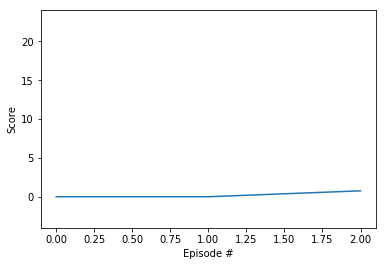

In [3]:
def plot_scores(scores, fig_indicator="normal"):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.plot(np.arange(len(scores)), scores)
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    plt.ylim((-4, 24))
    plt.show()
    
    fig_name = "Results/Figure_" + fig_indicator + ".png"
    fig.savefig(fig_name)
    
    np.save("Results/scores_" + fig_indicator + ".npy", scores)
    

def ddpg(n_episodes=2000, max_t=700):
    scores_deque = deque(maxlen=100)
    scores = []
    max_score = -np.Inf
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]      # reset the environment    
        states = env_info.vector_observations                  # get the current state (for each agent)
        agent.reset()
        score = np.zeros(num_agents)                          # initialize the score (for each agent)
        for t in range(max_t):
            
            actions = agent.act(states)
            env_info = env.step(actions)[brain_name]        # send the action to the environment

            next_states = env_info.vector_observations   # get the next state
            rewards = env_info.rewards                   # get the reward
            dones = env_info.local_done                  # see if episode has finished
            agent.step(states, actions, rewards, next_states, dones)
            states = next_states
            score += rewards
            
            if np.any(dones):
                break 
        scores_deque.append(np.mean(score))
        scores.append(np.mean(score))
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))   
        if i_episode % 100 == 0 or np.mean(scores_deque) >= 30.0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))   
        if np.mean(scores_deque)>=30.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
            break            
    return scores    

t = time.time()
scores = ddpg()
elapsed = time.time() - t # https://stackoverflow.com/questions/5849800/what-is-the-python-equivalent-of-matlabs-tic-and-toc-functions
print('\t Time to train network: {:.2f}'.format(elapsed), 'seconds')

plot_scores(scores, fig_indicator="ddpg_normal_soln_final")

### 4. Watch a Smart Agent!

The code below loads the trained weights from file to watch a smart agent. 

To visualize the trained environment,
 - change the __*visible_environment*__ variable to **True** in (**2. Instantiate the Environment and Agent**)
 - restart the kernel, and 
 - **skip** the previous section (**3. Train the Agent with DQN**).

In [ ]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

# load the weights from file
agent.actor_local.load_state_dict(torch.load('checkpoint_actor.pth'))
agent.critic_local.load_state_dict(torch.load('checkpoint_critic.pth'))

for i in range(1):
    env_info = env.reset(train_mode=False)[brain_name]
    states = env_info.vector_observations                  # get the current state (for each agent)
    for j in range(200):
        actions = agent.act(states)
        env_info = env.step(actions)[brain_name]        # send the action to the environment
        states = env_info.vector_observations
        dones = env_info.local_done                  # see if episode has finished
        
        if np.any(dones):
            break     

In [ ]:
env.close()